In [1]:
# Kaggle-ready EDA starter (auto-detect input CSV + safe read)
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 100)
plt.rcParams["figure.figsize"] = (10, 6)

# 0. Auto-detect CSV in /kaggle/input
DATA_PATH = Path("/kaggle/input/mfddmulti-modal-flight-delay-dataset/Aeolus/Flight_Tab/flight_with_weather_2024.csv")

SAMPLE_FRAC = 0.05  # 5% sample

def skip_random(i):
    if i == 0: return False
    return np.random.rand() > SAMPLE_FRAC

df = pd.read_csv(DATA_PATH, skiprows=skip_random, low_memory=True)
print(df.shape)
df.head()
print("Using:", DATA_PATH)
print("File size (GB):", DATA_PATH.stat().st_size / (1024**3))


(314181, 34)
Using: /kaggle/input/mfddmulti-modal-flight-delay-dataset/Aeolus/Flight_Tab/flight_with_weather_2024.csv
File size (GB): 1.6282783690840006


In [2]:
print("\n--- dtypes / non-null counts ---")
display(df.dtypes)
print("\n--- basic info ---")
display(df.info(memory_usage="deep"))

missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.concat([missing, missing_pct], axis=1)
missing_df.columns = ["missing_count", "missing_pct"]
print("\n--- top missing columns ---")
display(missing_df[missing_df["missing_count"] > 0].head(40))



--- dtypes / non-null counts ---


FL_DATE                 object
OP_CARRIER              object
OP_CARRIER_FL_NUM      float64
ORIGIN                  object
DEST                    object
CRS_DEP_TIME            object
DEP_TIME                object
DEP_DELAY              float64
TAXI_OUT               float64
WHEELS_OFF              object
WHEELS_ON               object
TAXI_IN                float64
CRS_ARR_TIME            object
ARR_TIME                object
ARR_DELAY              float64
CRS_ELAPSED_TIME       float64
ACTUAL_ELAPSED_TIME    float64
AIR_TIME               float64
FLIGHTS                float64
MONTH                    int64
DAY_OF_MONTH             int64
DAY_OF_WEEK              int64
ORIGIN_INDEX             int64
DEST_INDEX               int64
O_TEMP                 float64
O_PRCP                 float64
O_WSPD                 float64
D_TEMP                 float64
D_PRCP                 float64
D_WSPD                 float64
O_LATITUDE             float64
O_LONGITUDE            float64
D_LATITU


--- basic info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314181 entries, 0 to 314180
Data columns (total 34 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   FL_DATE              314181 non-null  object 
 1   OP_CARRIER           314181 non-null  object 
 2   OP_CARRIER_FL_NUM    314181 non-null  float64
 3   ORIGIN               314181 non-null  object 
 4   DEST                 314181 non-null  object 
 5   CRS_DEP_TIME         314181 non-null  object 
 6   DEP_TIME             314181 non-null  object 
 7   DEP_DELAY            314181 non-null  float64
 8   TAXI_OUT             314181 non-null  float64
 9   WHEELS_OFF           314181 non-null  object 
 10  WHEELS_ON            314181 non-null  object 
 11  TAXI_IN              314181 non-null  float64
 12  CRS_ARR_TIME         314181 non-null  object 
 13  ARR_TIME             314181 non-null  object 
 14  ARR_DELAY            314181 non-null  float64
 1

None


--- top missing columns ---


,missing_count,missing_pct
D_WSPD,40,0.01
D_PRCP,40,0.01
D_TEMP,40,0.01
O_WSPD,24,0.01
O_PRCP,24,0.01
O_TEMP,24,0.01


In [3]:
expected_cols = ["FL_DATE","OP_CARRIER","OP_CARRIER_FL_NUM","ORIGIN","DEST",
                 "CRS_DEP_TIME","DEP_TIME","DEP_DELAY","TAXI_OUT","WHEELS_OFF"]
present = [c for c in expected_cols if c in df.columns]
missing_expected = [c for c in expected_cols if c not in df.columns]
print("Present expected cols:", present)
if missing_expected:
    print("WARNING - missing expected cols:", missing_expected)


Present expected cols: ['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF']


In [4]:
def safe_to_datetime(series):
    # try normal parse, coerce errors to NaT
    return pd.to_datetime(series, errors="coerce")


In [5]:
for col in ["FL_DATE", "CRS_DEP_TIME", "DEP_TIME", "WHEELS_OFF"]:
    if col in df.columns:
        # if looks like full datetime strings, parse as-is
        if df[col].dropna().astype(str).str.contains(":").any():
            df[col + "_dt"] = safe_to_datetime(df[col])
        else:
            # maybe numeric HHMM or HHMMSS. We'll try to coerce into HH:MM:SS on FL_DATE date if available
            try:
                # treat values as floats with possible .0
                tmp = df[col].dropna().astype(int).astype(str)
                # pad left with zeros
                tmp = tmp.str.zfill(6)  # HHMMSS or HHMM => gets padded
                # create time strings HH:MM:SS
                time_str = tmp.str.replace(r"(\d{2})(\d{2})(\d{2})", r"\1:\2:\3", regex=True)
                # If FL_DATE exists, merge date + time, else just parse time with today's date
                if "FL_DATE" in df.columns:
                    date_part = pd.to_datetime(df["FL_DATE"], errors="coerce").dt.date.astype(str)
                    combined = date_part + " " + time_str
                    df[col + "_dt"] = pd.to_datetime(combined, errors="coerce")
                else:
                    df[col + "_dt"] = pd.to_datetime(time_str, errors="coerce").dt.time
            except Exception:
                df[col + "_dt"] = pd.to_datetime(df[col], errors="coerce")


In [6]:
for src in ["CRS_DEP_TIME_dt", "DEP_TIME_dt", "WHEELS_OFF_dt"]:
    if src in df.columns:
        df[src.replace("_dt", "_hour")] = df[src].dt.hour
        df[src.replace("_dt", "_weekday")] = df[src].dt.weekday

display(df[[c for c in df.columns if "_dt" in c or "_hour" in c or "_weekday" in c]].head())


,FL_DATE_dt,CRS_DEP_TIME_dt,DEP_TIME_dt,WHEELS_OFF_dt,CRS_DEP_TIME_hour,CRS_DEP_TIME_weekday,DEP_TIME_hour,DEP_TIME_weekday,WHEELS_OFF_hour,WHEELS_OFF_weekday
0,2024-01-01,2024-01-01 15:59:00,2024-01-01 15:57:00,2024-01-01 16:15:00,15,0,15,0,16,0
1,2024-01-01,2024-01-01 20:10:00,2024-01-01 20:18:00,2024-01-01 20:39:00,20,0,20,0,20,0
2,2024-01-08,2024-01-08 07:00:00,2024-01-08 07:03:00,2024-01-08 07:32:00,7,0,7,0,7,0
3,2024-01-17,2024-01-17 12:29:00,2024-01-17 13:41:00,2024-01-17 14:06:00,12,2,13,2,14,2
4,2024-01-20,2024-01-20 09:50:00,2024-01-20 10:08:00,2024-01-20 10:25:00,9,5,10,5,10,5


In [7]:
if "DEP_DELAY" in df.columns:
    df["Delayed"] = (df["DEP_DELAY"] > 15).astype(int)
    print("Using DEP_DELAY as target.")
else:
    # fallback: if ARR_DELAY existed, you could use it; here we warn
    raise KeyError("DEP_DELAY column not found. Please confirm column name for delays.")

print("\nTarget distribution:")
display(df["Delayed"].value_counts())
display((df["Delayed"].value_counts(normalize=True) * 100).round(2))


Using DEP_DELAY as target.

Target distribution:


Delayed
0    251164
1     63017
Name: count, dtype: int64

Delayed
0    79.94
1    20.06
Name: proportion, dtype: float64

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


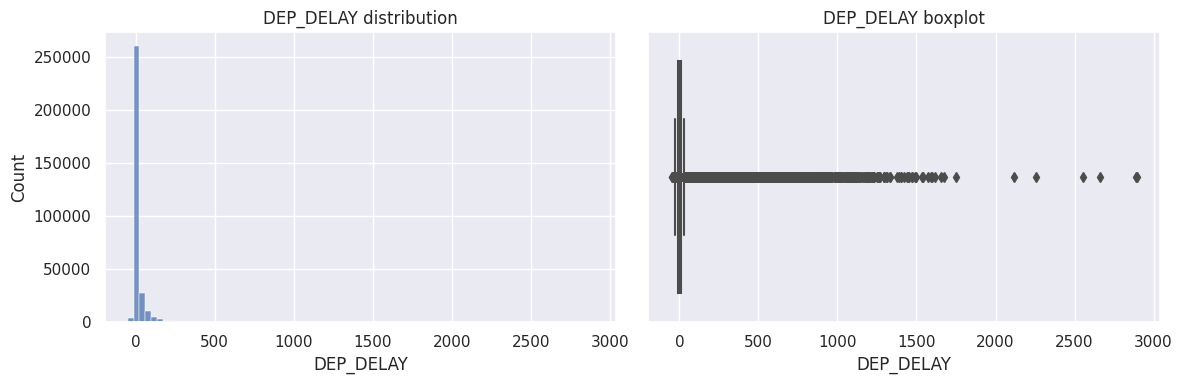

In [8]:
if "DEP_DELAY" in df.columns:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(df["DEP_DELAY"].dropna(), bins=80, kde=False)
    plt.title("DEP_DELAY distribution")
    plt.subplot(1,2,2)
    sns.boxplot(x=df["DEP_DELAY"].dropna())
    plt.title("DEP_DELAY boxplot")
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


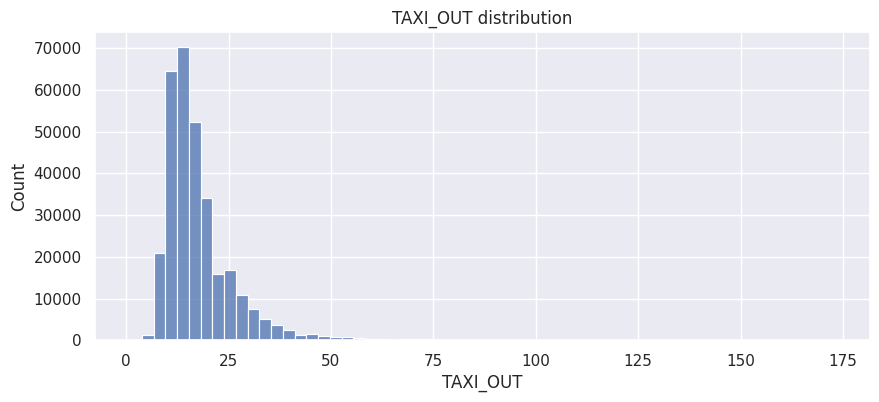

In [9]:
if "TAXI_OUT" in df.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(df["TAXI_OUT"].dropna(), bins=60)
    plt.title("TAXI_OUT distribution")
    plt.show()



Top 10 values for OP_CARRIER:


OP_CARRIER
WN    64189
DL    45796
AA    44296
UA    33942
OO    32505
YX    13418
MQ    12754
NK    11571
AS    10854
B6    10454
Name: count, dtype: int64

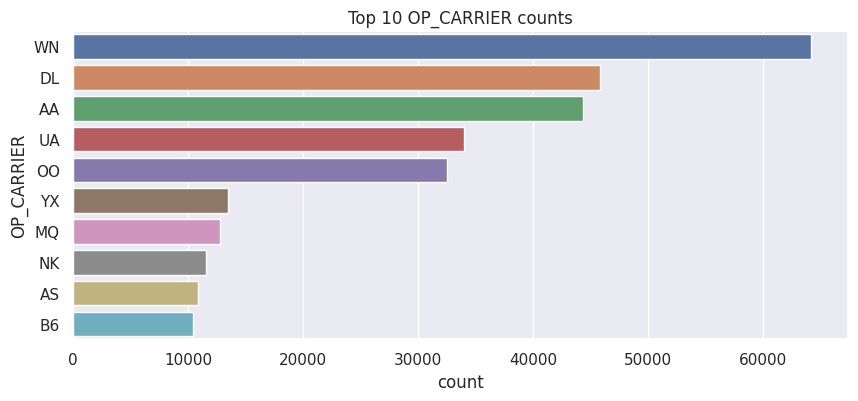


Top 10 values for ORIGIN:


ORIGIN
ATL    15527
DFW    14249
DEN    13582
ORD    12671
CLT     9708
LAX     8781
PHX     8670
LAS     8530
SEA     7499
LGA     7196
Name: count, dtype: int64

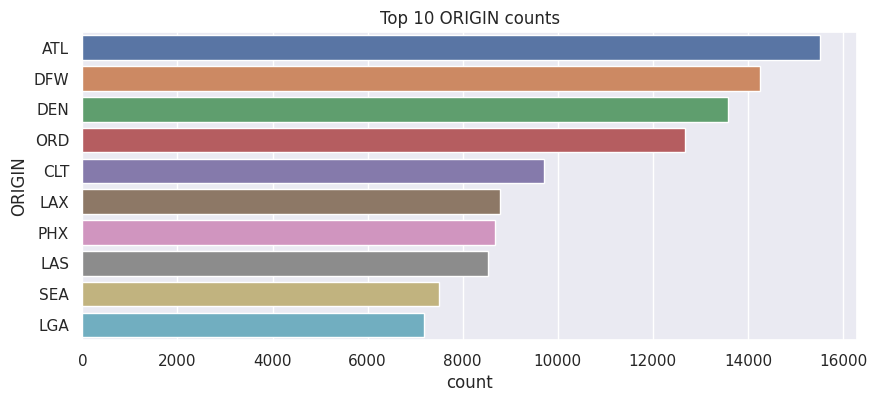


Top 10 values for DEST:


DEST
ATL    15418
DFW    14047
DEN    13710
ORD    12520
CLT     9947
PHX     8791
LAX     8630
LAS     8625
SEA     7342
LGA     7220
Name: count, dtype: int64

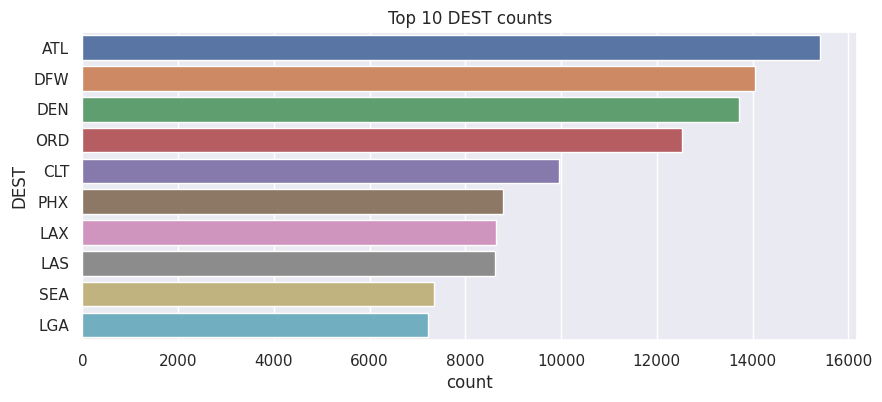

In [10]:
cat_cols = ["OP_CARRIER","ORIGIN","DEST"]
for c in cat_cols:
    if c in df.columns:
        print(f"\nTop 10 values for {c}:")
        display(df[c].value_counts().head(10))
        plt.figure(figsize=(10,4))
        sns.countplot(y=c, data=df, order=df[c].value_counts().head(10).index)
        plt.title(f"Top 10 {c} counts")
        plt.show()



Top 10 OP_CARRIER by frequency with delay rate:


,OP_CARRIER,mean,count,delay_pct
13,WN,0.220957,64189,22.10
4,DL,0.169098,45796,16.91
1,AA,0.248194,44296,24.82
12,UA,0.185434,33942,18.54
11,OO,0.170251,32505,17.03
14,YX,0.116038,13418,11.60
8,MQ,0.189666,12754,18.97
9,NK,0.231614,11571,23.16
2,AS,0.193753,10854,19.38
3,B6,0.248996,10454,24.90


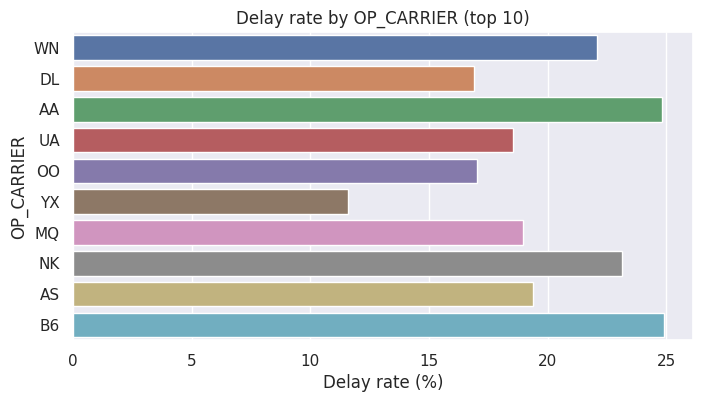


Top 10 ORIGIN by frequency with delay rate:


,ORIGIN,mean,count,delay_pct
19,ATL,0.195981,15527,19.60
82,DFW,0.265703,14249,26.57
81,DEN,0.223973,13582,22.40
218,ORD,0.218767,12671,21.88
63,CLT,0.253399,9708,25.34
168,LAX,0.167635,8781,16.76
227,PHX,0.191580,8670,19.16
166,LAS,0.224502,8530,22.45
264,SEA,0.198693,7499,19.87
174,LGA,0.171901,7196,17.19


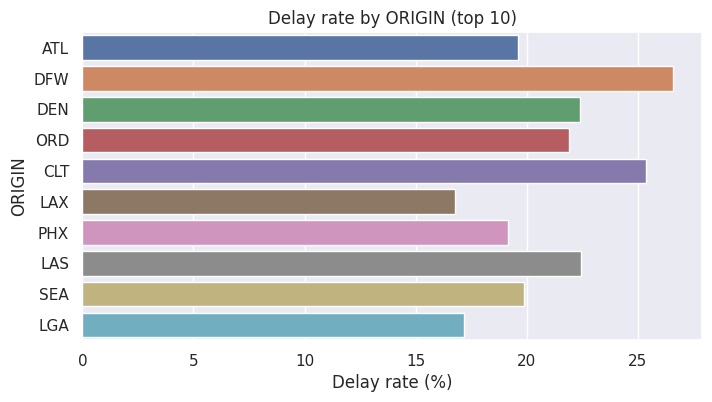


Top 10 DEST by frequency with delay rate:


,DEST,mean,count,delay_pct
19,ATL,0.169672,15418,16.97
82,DFW,0.228447,14047,22.84
81,DEN,0.183662,13710,18.37
217,ORD,0.181470,12520,18.15
63,CLT,0.204484,9947,20.45
226,PHX,0.180753,8791,18.08
167,LAX,0.190962,8630,19.10
165,LAS,0.220058,8625,22.01
263,SEA,0.179651,7342,17.97
173,LGA,0.185042,7220,18.50


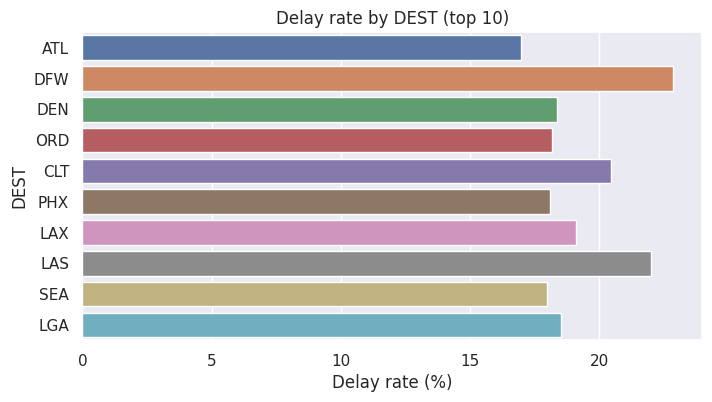

In [11]:
groupby_cols = ["OP_CARRIER","ORIGIN","DEST"]
for c in groupby_cols:
    if c in df.columns:
        tmp = df.groupby(c)["Delayed"].agg(["mean","count"]).reset_index().sort_values("count", ascending=False)
        tmp["delay_pct"] = (tmp["mean"]*100).round(2)
        print(f"\nTop 10 {c} by frequency with delay rate:")
        display(tmp.head(10))
        # plot delay rate for top 10 by frequency
        top10 = tmp.head(10)
        plt.figure(figsize=(8,4))
        sns.barplot(x="delay_pct", y=c, data=top10, orient="h")
        plt.xlabel("Delay rate (%)")
        plt.title(f"Delay rate by {c} (top 10)")
        plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


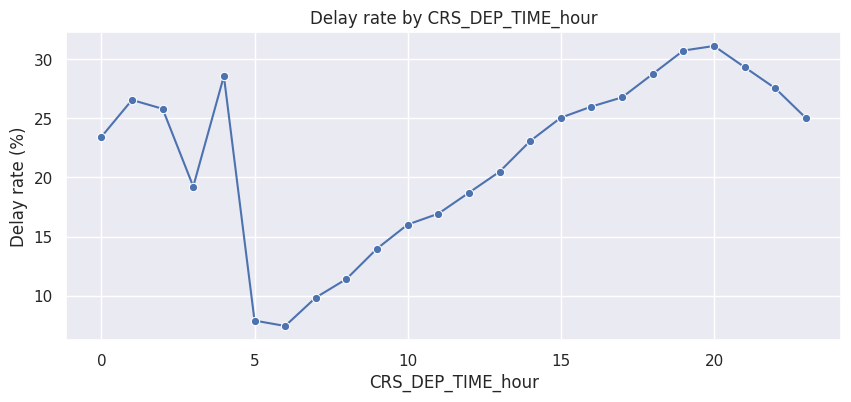

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


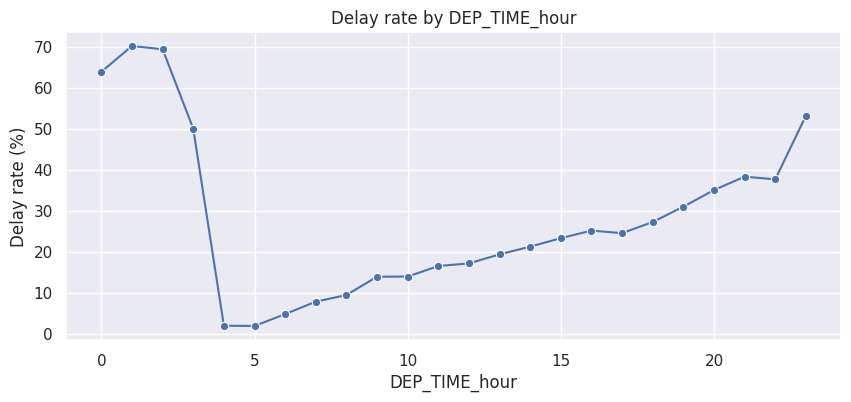

In [12]:
for hour_col in ["CRS_DEP_TIME_hour", "DEP_TIME_hour"]:
    if hour_col in df.columns:
        tmp = df.groupby(hour_col)["Delayed"].mean().reset_index()
        tmp["delay_pct"] = tmp["Delayed"]*100
        plt.figure(figsize=(10,4))
        sns.lineplot(x=hour_col, y="delay_pct", data=tmp, marker="o")
        plt.title(f"Delay rate by {hour_col}")
        plt.ylabel("Delay rate (%)")
        plt.show()


In [13]:
num_cols = ["DEP_DELAY","TAXI_OUT"]
num_present = [c for c in num_cols if c in df.columns]
if len(num_present) > 0:
    display(df[num_present].describe().T)
    # simple pairplot if small enough
    if len(df) <= 5000:
        sns.pairplot(df[num_present + ["Delayed"]].dropna(), hue="Delayed", vars=num_present)
        plt.show()


,count,mean,std,min,25%,50%,75%,max
DEP_DELAY,314181.0,12.597251,54.910780,-50.0,-6.0,-2.0,9.0,2894.0
TAXI_OUT,314181.0,17.946302,9.672027,1.0,12.0,15.0,21.0,173.0


In [14]:
out_dir = Path("/kaggle/working/eda_outputs")
out_dir.mkdir(parents=True, exist_ok=True)
missing_df.to_csv(out_dir / "missing_summary.csv")
if "Delayed" in df.columns:
    df["Delayed"].value_counts().to_csv(out_dir / "target_counts.csv")
print("EDA artifacts saved to:", out_dir)


EDA artifacts saved to: /kaggle/working/eda_outputs
